RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# custom libraries
from nlp.preparer import Corpus
from nlp.iterator import BatchIterator

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 6666 articles,  av length: 321 words,  max length: 4977 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'февраля', 'в', 'большинстве', 'европейских', 'стран', 'закрылось', 'зимнее', 'трансферное', 'окно', 'период', ',', 'когда', 'клубы', 'могут', 'заявлять', 'новых', 'футболистов', ',', 'купленных']

Corpus label: bad,  length: 7519 articles,  av length: 84 words,  max length: 594 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестный', 'угрожает', 'взорвать', 'аэропорт', 'кишинева', ',', 'если', 'ему', 'не', 'дадут', 'миллион', '.', 'неизвестный',

### Visualizing articles lengths

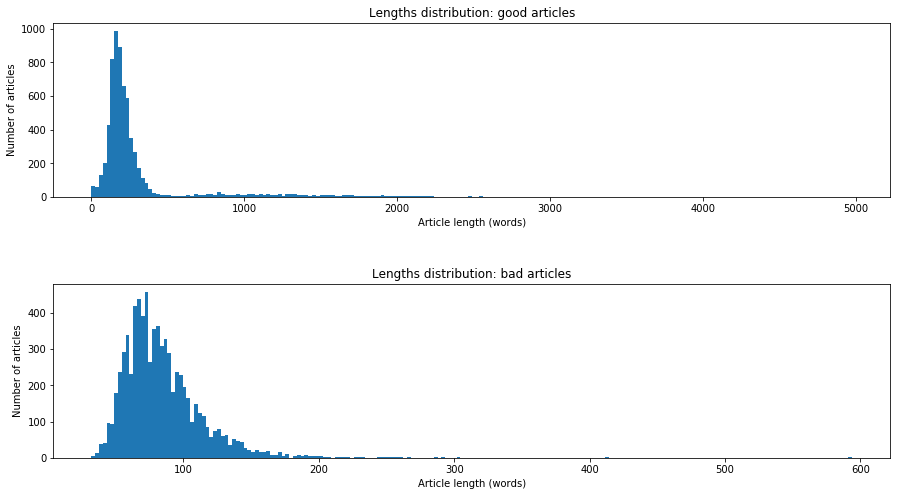

In [3]:
# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[0].label} articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[1].label} articles')
plt.hist(lengths[1], 200)

plt.show()

### Building a dictionary

In [3]:
validation_size = 20 # articles per each class
vocabulary_size = 25000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

dictionary, reverse_dictionary, count = build_dictionary(all_words)
good_data = [build_dataset(article, dictionary, count) for article in corpora[0].articles]
bad_data  = [build_dataset(article, dictionary, count) for article in corpora[1].articles]

# Splitting between train and validation datasets
good_train_data = good_data[:-validation_size]
good_validation_data = good_data[-validation_size:]
bad_train_data = bad_data[:-validation_size]
bad_validation_data = bad_data[-validation_size:]
validation_data = [item for ga, ba in zip(good_validation_data, bad_validation_data) for item in [ga, ba]]

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}\n")
print(f'Example data: {good_data[0][:20]}\n')
print(f'Validation sizes split train / validation: {len(good_train_data)} / {len(good_validation_data)}')
print(f'Validation dataset size: {len(validation_data)}')

Top popular words counts: [['UNK', 311785], (',', 191060), ('.', 167323), ('в', 121865), ('num', 70531), ('и', 59437), ('на', 47376), ('с', 26509), ('что', 22411), ('по', 21883), ('не', 20173), ('из', 16359), (')', 12317), ('(', 12286), ('как', 11494)]

Example word: 23732 => слон

Example data: [4, 344, 3, 3705, 2011, 282, 0, 10653, 0, 4102, 586, 1, 67, 5320, 152, 0, 448, 8138, 1, 22380]

Validation sizes split train / validation: 6646 / 20
Validation dataset size: 40


Below is an **example** of two training batches spat out by `BatchIterator`:

In [4]:
batch_size = 20
good = [1, 0] # Representation of first class
bad  = [0, 1] # Representation of second class

batches = BatchIterator(batch_size, good_train_data, bad_train_data, good, bad)

for i in range(20):
  batch = batches.next()
  if i > 17: print(batch)

batches.rewind()

[[0, 1995, 0, 2, 190, 6285, 3, 0, 0, 15, 4, 201, 290, 1, 228, 3, 5438, 0, 15, 4], [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[201, 2, 1185, 3249, 6873, 1502, 0, 1, 75, 157, 10, 8778, 1533, 2, 1185, 103, 18, 9826, 3, 724], [[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


## 2. LSTM Model

In [5]:
num_nodes = 64 # Dimension of lstm cell
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
num_unrollings = 20 # Number of recurrent steps

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, num_classes], -0.1, 0.1))
  b = tf.Variable(tf.zeros([num_classes]))
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    # Create an LSTM cell
    input_gate =  tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs         = tf.placeholder(tf.int32, shape=[num_unrollings])
  train_state_cleaners = tf.placeholder(tf.float32, shape=[num_unrollings])
  train_labels         = tf.placeholder(tf.int32, shape=[num_unrollings, num_classes])

  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state  = saved_state
  lstm_inputs = tf.unstack(tf.nn.embedding_lookup(embeddings, train_inputs)) # ~ (num_unrollings, embedding_size)
  lstm_state_cleaners = tf.unstack(train_state_cleaners)

  for lstm_input, state_cleaner in zip(lstm_inputs, lstm_state_cleaners):
    reshaped_lstm_input = tf.reshape(lstm_input, (1, embedding_size))
    output, state = lstm_cell(reshaped_lstm_input,
                              tf.multiply(state_cleaner, output),
                              tf.multiply(state_cleaner, state))
    lstm_outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(lstm_outputs, 0), w, b) # ~ (num_unrollings, num_classes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=train_labels,
      logits=logits
    ))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    5.0, global_step, 4000, 0.6, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.int32, shape=[1])
  sample_lstm_input = tf.nn.embedding_lookup(embeddings, sample_input)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_lstm_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

## 3. Training

In [14]:
def represent(words, predicted_classes):
  label = colored(['=>'], predicted_classes[-1:])[0]
  article = " ".join(colored(words, predicted_classes))

  return f"{label} {article}"

def colored(words, labels):
  colors = []
  for label in labels:
    if abs(label[0] - label[1]) < 0.2: color = 'black'
    elif label[0] > label[1]:          color = 'green'
    else:                              color = 'red'

    colors.append(color)

  return [colored_word(word, color) for word, color in zip(words, colors)]

def colored_word(word, color='black'):
  colors = { 'black':'30',
             'red':'31',
             'green':'32',
             'yellow':'33',
             'blue':'34',
             'purple':'35',
             'sea-blue':'36' }

  return f"\x1b[{colors[color]}m{word}\x1b[0m"


def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

In [ ]:
num_steps = 30001
summary_frequency = 100
validation_frequency = 5000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  losses = []
  perpls = []
  for step in range(num_steps):
    batch = batches.next()
    feed_dict = { train_inputs: batch[0],
                  train_labels: batch[1],
                  train_state_cleaners: batch[2] }
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l

    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      labels = np.array(batch[1])
      perpl = float(np.exp(logprob(predictions, labels)))
      print(
        'Average loss at step %d: %.4f, perplexity: %.2f, learning rate: %.4f' % (step, mean_loss, perpl, lr))

      losses.append(mean_loss)
      perpls.append(perpl)
      mean_loss = 0

      if step % (summary_frequency * 20) == 0:
        print('=' * 80)
        for article in validation_data:
          reset_sample_state.run()
          predicted = []
          article_as_words = []
          for word in article:
            article_as_words.append(reverse_dictionary[word])
            prediction = sample_prediction.eval({ sample_input: [word] })
            predicted.append(prediction[0])

          print(represent(article_as_words, predicted))
#           print(" ".join(article_as_words[:5]))
#           print(f'{predicted[-1]} => {}')
        print('=' * 80)

#       if step % (summary_frequency * 10) == 0:
#         # Generate some samples.
#         print('=' * 80)
#         for _ in range(5):
#           feed = sample(random_distribution())
#           sentence = characters(feed)[0]
#           reset_sample_state.run()
#           for _ in range(79):
#             prediction = sample_prediction.eval({sample_input: feed})
#             feed = sample(prediction)
#             sentence += characters(feed)[0]
#           print(sentence)
#         print('=' * 80)
#       # Measure validation set perplexity.
#       reset_sample_state.run()
#       valid_logprob = 0
#       for _ in range(valid_size):
#         b = valid_batches.next()
#         predictions = sample_prediction.eval({sample_input: b[0]})
#         valid_logprob = valid_logprob + logprob(predictions, b[1])
#       print('Validation set perplexity: %.2f' % float(np.exp(
#         valid_logprob / valid_size)))

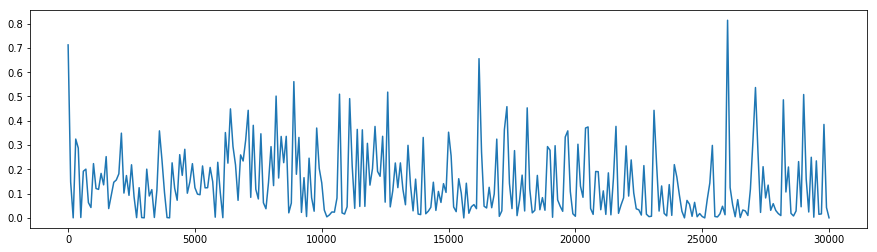

In [16]:
plt.figure().set_size_inches(15, 4)

plt.plot([n * summary_frequency for n in range(0, len(losses))], losses)
plt.show()

In [49]:
print(colored("red", color="purple"))


red
